<h1> 2. Back-propagation (BP) from Scratch <h1>

En esta sección, se implementará el algoritmo Back-propagation (de ahora en adelante, BP), frecuentemente utilizado en el entrenamiento de redes neuronales *feedforward*.

**2.0 Importaciones necesarias**

In [12]:
import random
import math
import sklearn
from sklearn import preprocessing
import pandas
import matplotlib
from matplotlib import pyplot

**2.1 Entrenamiento de red *feedforward* vía BP**

**2.1.1 Inicialización de la red**

En primer lugar, es necesario definir el tipo de dato que se utilizará para implementar la red, así como también el de cada de uno de sus componentes (capas y neuronas). Cada neurona será un diccionario que almacena los pesos asociados a ella. Luego, cada capa será implementada como un arreglo de neuronas y a su vez, la red completa será un arreglo de capas. Se considerará que cada red posee sólo una capa oculta.

Por otro lado, sea I la dimensionalidad de cada input, H el número de neuronas de la capa oculta y O el número de neuronas de la capa oculta (o en otras palabras, la cantidad de clases existentes en el problema de clasificación respectivo). Teóricamente, a cada neurona de la capa oculta se le asocian I + 1 pesos, por lo que dicha capa tiene un total de H x (I + 1) pesos asociados. Además, a cada neurona de la capa de salida le corresponden H + 1 pesos, sumando un total de O x (H + 1) pesos para esta capa. Notar que se ha sumado 1 en cada caso para considerar el *bias*.

De esta manera, se procede a implementar la función *init_network*, que recibe a I, H y O como parámetros, y genera como salida una red *feedforward* con una capa oculta y una capa de salida, compuestas por H y O neuronas, respectivamente. Los pesos son determinados de forma aleatoria con valores entre 0 y 1. Por simplicidad, el *bias* es incluído como un peso más.

In [13]:
def init_network(I, H, O):
    # Se inicializa red feedforward vacía
    ff_network = []
    # Se implementa capa oculta, compuesta por H neuronas e H x (I + 1) pesos 
    hidden_layer = [{'weights': [random.random() for i in range (I + 1)]} for j in range (H)]
    # Se implementa capa de salida, compuesta por O neuronas y O x (H + 1) pesos
    output_layer = [{'weights': [random.random() for i in range (H + 1)]} for j in range (O)]
    # Se agregan las capas a la red
    ff_network.extend([hidden_layer, output_layer])
    return ff_network

**2.1.2 Implementación de *forward pass***

En esta sección, se implementará lo que se conoce como *forward-propagation*. Se denomina *forward-propagation* al proceso de generar una respuesta a partir de la propagación de un input determinado a través de las capas de una red neuronal artificial. Dicho proceso es vital en la fase de entrenamiento de la red, pues posibilita que los pesos de cada neurona sean modificados en base al output generado. De forma análoga, será vital para la realización de pruebas sobre inputs no conocidos en la sección 2.3.

Para realizar este procedimiento, primero es necesario determinar la **activación de cada neurona**, que corresponde a la suma ponderada de las variables asociadas a un determinado input en base a su peso. Luego, se implementa la función *neuron_activation* que, a partir de un determinado input y sus pesos, determina el valor de la activación.

In [14]:
def neuron_activation(input_, weights):
    # Se inicializa activación en 0
    activation = 0
    for i in range(len(weights) - 1):
        activation += weights[i] * input_[i]
    # Se suma bias
    activation += weights[-1]
    return activation

Después de que cada neurona es activada, es necesario **transferir la activación**, esto es, aplicar una función no lineal sobre la activación obtenida previamente. Por tanto, se debe escoger una función de este tipo para realizar la transferencia. En este caso, se utilizará la función *tanh* para ambas capas.

Teniendo esta función implementada, se está en condiciones de realizar el forward pass. Para ello, se implementa la función *forward pass*, que recibe la red completa y un input determinado como parámetros. Así, por cada capa, se calcula el output producido por cada una de las neuronas que forman parte de ella, de tal forma que los outputs de una capa corresponden a los inputs de la siguiente. En este caso, los outputs de la capa oculta son los inputs de la capa de salida. Recordar que hasta este momento, las neuronas están almacenando los pesos que se le asocian. Gracias a esta función, cada neurona también almacenará el output que produce a partir del input y de los pesos.

In [15]:
def forward_pass(network, input_):
    for layer in network:
        output = []
        for neuron in layer:
            # Se realiza activación de cada neurona
            activation = neuron_activation(input_, neuron['weights'])
            # Se realiza transferencia por medio de función tanh
            neuron['output'] = math.tanh(activation)
            output.append(neuron['output'])
            # Los outputs de la capa oculta corresponden a los inputs de la capa de salida
        input_ = output
    return output

**2.1.3 Implementación de *backward pass***

Una vez obtenidos los outputs a partir de un input determinado, es necesario calcular el error asociado a cada uno de los outputs individuales. A continuación, estos errores son "informados" a la capa oculta por medio de la capa de salida, de tal manera que los pesos asociados a cada neurona son recalculados.

Para realizar este proceso, primero se requiere **evaluar la derivada de la función de transferencia sobre los outputs**. La derivada de la función *tanh* es:

**f'(x) = 1 - tanh<sup>2</sup>(x)**

Luego, se procede a implementar la derivada de esta función.

In [16]:
# Implementación de la derivada de la función tanh
def tanh_derivative(output):
    return 1 - math.tanh(output) ** 2

En seguida, se requiere **definir como se calculará el error asociado a cada neurona de la capa oculta**. Para esto, primero es necesario calcular el error asociado a cada neurona presente en la capa de salida, el que puede definirse como:

**error_neurona_capa_salida = (valor_real - valor_calculado) x f'(valor_calculado)**

Sin embargo, la forma de calcular el error asociado a cada neurona en la capa oculta es diferente. Dicho error se obtiene a partir de la suma ponderada de los errores de las neuronas de la capa de salida por sus pesos, es decir:

**error_neurona_capa_oculta_i = sumatoria (peso_ij x error_neurona_capa_salida_j) x f'(valor_calculado)**

Con esta idea en mente, se implementa la función *backward_pass*, que recibe la red completa y un arreglo con los valores esperados. Lo que hace esta función es almacenar en cada neurona presente en la red el error calculado para ella (en términos de código, esto implica adicionar una nueva llave al diccionario).

In [17]:
def backward_pass(network, expected_values):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = []
        # Primero se computan los errores en la capa de salida
        if i == len(network) - 1:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected_values[j] - neuron['output'])
        
        # Luego, se calcula el error de cada neurona de la capa oculta a partir de los errores de las neuronas de la capa
        # de salida
        else:
            for j in range(len(layer)):
                error = 0
                # Se realiza la suma ponderada sobre las neuronas de la capa de salida
                for neuron in network[i + 1]:
                    error += neuron['weights'][j] * neuron['error']
                errors.append(error)
        
        # Para cada capa, se multiplica el error de cada neurona por la derivada de la función de transferencia evaluada
        # en el output de dicha neurona
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['error'] = errors[j] * tanh_derivative(neuron['output'])    

**2.1.4 Entrenamiento**

Estando implementados tanto el *backward pass* como el *forward pass*, es posible dar paso a la construcción del proceso de entrenamiento del modelo. En este caso, se utilizará Gradiente Descendente Estocástico (de ahora en adelante, SGD) para ello. Dicho proceso involucra la ejecución de múltiples iteraciones. En cada una, los ejemplos son propagados a través de la red, para luego "devolver" los errores correspondientes a cada neurona y así poder actualizar los pesos de cada una. Un peso determinado es actualizado de la siguiente forma:

**peso_i = peso_i-1 + tasa_de_aprendizaje x error_i-1 x input**

Donde *peso_i* es el nuevo peso de la neurona, *peso_i-1* es su peso actual, *error_i-1* corresponde al error asociado a cada neurona por medio del *backward pass* e *input* es el valor que causó el error. Por otra parte, *tasa_de_aprendizaje* es un parámetro que permite controlar que tanto influye el error asociado a una neurona en la actualización de sus pesos y puede interpretarse como una medida de que tan rápido aprende el modelo, pues mientras mayor es esta tasa, mayor es el cambio que experimentan los pesos.

Notar que los pesos son actualizados por medio de un **método iterativo**.

Es importante tener en cuenta lo que ocurre con los *bias*. Como no están conectados a ninguna variable del input, sólo se considera la tasa de aprendizaje y el error, de tal forma que:

**bias_i = bias_i-1 + tasa_de_aprendizaje x error_i-1**

Así, se procede a implementar la función *update_weights*, la cual se encargará de actualizar los pesos de la red. Esta función recibe la red completa, la tasa de aprendizaje y un input determinado como parámetros obligatorios. Como parámetro optativo, está *weight_decay*, que por ahora no será utilizado (ver sección 2.4 para más detalle). Como salida, se entrega la red con sus pesos actualizados.

In [18]:
# Se actualizan pesos de la red
def update_weights(network, learning_rate, input_, weight_decay=None):
    for i in range(len(network)):
        # Pesos y bias son actualizados de forma diferente
        input_ = input_[:-1]
        # Los outputs de la capa oculta corresponden a los inputs de la capa de salida
        if i != 0:
            input_ = [neuron['output'] for neuron in network[i-1]]
            
        # Por cada capa...
        for neuron in network[i]:
            # ... se actualizan pesos de cada neurona...
            for j in range(len(input_)):
                if weight_decay:
                    neuron['weights'][j] += learning_rate * neuron['error'] * input_[j] - learning_rate * weight_decay * \
                        neuron['weights'][j]
                else:
                    neuron['weights'][j] += learning_rate * neuron['error'] * input_[j]
            # Y finalmente el bias
            neuron['weights'][-1] += learning_rate * neuron['error']

Con esto, se está en condiciones de implementar el entrenamiento de la red, proceso que basicamente consistirá en realizar, sobre cada ejemplo perteneciente a un determinado conjunto de entrenamiento, un *forward pass*, un *backward pass* y actualización de pesos, siendo este proceso repetido tantas veces como iteraciones (en este contexto, *épocas*) se desee. Luego, se procede a implementar la función *train_network*, que lleva a cabo el proceso previamente descrito. Esta función recibe una red inicializada aleatoriamente, un conjunto de entrenamiento, tasa de aprendizaje, número de épocas, número de clases del problema como parámetros obligatorios. Como parámetro optativo, está *weight_decay*, no utilizado por ahora. Como salida, se entrega la red entrenada junto con el valor promedio de la función objetivo en la última iteración del entrenamiento.

Notar que a cada ejemplo le corresponde un vector binario que indica su clase, de tal forma que si pertenece a la clase i, este vector tendrá un 1 en la posición y ceros en las posiciones restantes. Esto es necesario para poder comparar el vector de outputs generado por la capa de salida con los valores esperados. Luego, la función objetivo está definida, para cada ejemplo, como:

**f = sumatoria(vector_binario_i - probabilidad_clase_i)<sup>2</sup>**

Por ejemplo, suponer que se tiene un problema de clasificación binario y que el vector binario de un determinado ejemplo es [0, 1], mientras que el output que se generó para este (es decir, la probabilidad asociada a cada clase) es [0.64, 0.36]. Luego, la función objetivo, para este ejemplo en específico, esta dada por:

f = (0 - 0.64)<sup>2</sup> + (1 * 0.36)<sup>2</sup>

In [61]:
# Se entrena una red determinada
def train_network(network, train_dataset, learning_rate, n_epochs, n_classes, weight_decay=None):
    # Se determina el valor de la función objetivo en cada iteración, para luego calcular su valor promedio
    loss_function = 0.0
    for epoch in range(n_epochs):
        # Para cada ejemplo del conjunto de entrenamiento...
        for example in train_dataset:
            # ... se realiza, en primer lugar, el forward pass
            output = forward_pass(network, example)
            # se define vector binario asociado al ejemplo
            example_class = int(example[-1] - 1)
            expected_values = [0 for i in range(n_classes)]
            expected_values[example_class] = 1
            # Se lleva a cabo backward pass
            backward_pass(network, expected_values)
            # Se actualizan los pesos de la red
            # Se utiliza weight decay, en caso de que este parametro sea especificado
            update_weights(network, learning_rate, example, weight_decay)
        # Si se está en la última iteración, se calcula el valor total de la función objetivo
            if epoch == n_epochs - 1:
                loss_function += sum([(expected_values[i] - output[i])**2 for i in range(len(expected_values))])
    # Se retorna el valor promedio de la función objetivo
    return loss_function / len(train_dataset)

**2.2 Realizando predicciones sobre una red *feed forward***

A continuación, se implementa la función *predict_classes*, cuyo propósito es realizar predicciones sobre un conjunto de pruebas. Para ello, se hará uso de la función *forward_pass*. Se sabe que esta función genera un vector de dimensionalidad igual al número de clases del problema y que el elemento i-ésimo de dicho vector corresponde a la probabilidad de que el ejemplo propagado a través de la red de pertenezca a la clase i. Luego, el ejemplo pertenecerá a la clase que le corresponda la mayor probabilidad.

*predict_classes* recibe una red previamente entrenada y un conjunto de pruebas como parámetros. Como salida, entrega el error de clasificación promedio obtenido sobre el conjunto de pruebas. 

In [62]:
# Se implementa prediccion sobre ejemplos de prueba
def predict_classes(network, test_dataset):
    # Se lleva un conteo de ejemplos mal clasificados
    misclassified_examples = 0.0
    for example in test_dataset:
        # Se generan probabilidades
        output = forward_pass(network, example)
        # Se obtiene clase asociada a la mayor probabilidad
        example_predicted_class = output.index(max(output)) + 1
        # Se verifica si el ejemplo fue bien o mal clasificado
        if example_predicted_class != example[-1]:
            misclassified_examples += 1
    # Se retorna la proporción de ejemplos mal clasificados respecto al total y
    # la función de perdida promedio del dataset 
    return misclassified_examples / len(test_dataset)

**2.3 Aplicación sobre problema real**

En esta sección, se busca comprobar el funcionamiento de los algoritmos implementados sobre un dataset real, *seeds*, utilizado para la clasificación de semillas. El dataset está constituido por 210 ejemplos. Además, cada ejemplo está definido por 7 atributos y se definen 3 clases de semilla. Los datos serán normalizados previo a su utilización.

El dataset original es dividido en 168 ejemplos de entrenamiento (80% del dataset) y 42 ejemplos de prueba (20% del dataset). 

In [63]:
# Se descarga y almacena dataset en un dataframe
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
df = pandas.read_csv(url, sep=r'\s+', header=None)
# Se normaliza dataframe
scaler = sklearn.preprocessing.StandardScaler().fit(df.ix[:, 0:6])
df.ix[:, 0:6] = scaler.transform(df.ix[:, 0:6])
# Se convierte el dataset a formato lista, el cual es utilizado por las funciones implementadas en las secciones previas
dataset = df.values.tolist()
# Se genera conjunto de entrenamiento
train_dataset = dataset[:int(math.floor(0.8 * len(dataset)))]
# Se genera conjunto de pruebas
test_dataset = dataset[int(math.floor(0.8 * len(dataset))):]

Generados el conjunto de entrenamiento y el conjunto de pruebas, se procede a entrenar la red sobre el conjunto de entrenamiento, para luego realizar predicciones sobre este y el conjunto de pruebas. Se usará una tasa de aprendizaje de 0.03 y una cantidad variable de épocas (desde 10 hasta 100, aumentando de 5 en 5). La capa oculta de la red estará constituida por 10 neuronas, mientras que la capa de salida por 3 neuronas.

In [64]:
# Se define tasa de aprendizaje
learning_rate = 0.03
# Se define cantidad maxima de épocas
max_epochs = 100

# Se obtiene cantidad de atributos de cada ejemplo (en este caso, 7)
n_features = len(train_dataset[0]) - 1
# Se obtiene cantidad de clases (en este caso, 3)
n_classes = len(set([row[-1] for row in train_dataset]))
# Se inicializa red
random.seed(1)
network = init_network(n_features, 10, n_classes)

epochs = []
# Se almacenan errores y funciones de perdida para cada número de épocas posible
train_errors = []
test_errors = []
loss_functions = []

# Para cada cantidad de épocas posible...
for i in range(10, max_epochs + 5, 5):
    # ... se entrena la red, obteniendo el valor promedio de la función objetivo...
    loss_function = train_network(network, train_dataset, learning_rate, i, n_classes)
    # ... y el error de clasificación
    train_error = predict_classes(network, train_dataset)
    test_error = predict_classes(network, test_dataset)
    epochs.append(i)
    train_errors.append(train_error)
    test_errors.append(test_error)
    loss_functions.append(loss_function)

Luego de obtener los errores de entrenamiento y de prueba para cada número de épocas posible, se procede a graficar error v/s número de épocas.

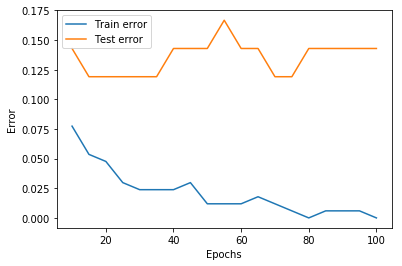

In [65]:
pyplot.plot(epochs, train_errors)
pyplot.plot(epochs, test_errors)
pyplot.xlabel('Epochs')
pyplot.ylabel('Error')
pyplot.legend(['Train error', 'Test error'], loc='upper left')
pyplot.show()

En este gráfico, se observa como el error de entrenamiento disminuye paulatinamente a medida que aumenta la cantidad de épocas, presentando sólo algunos leves incrementos en el camino. El error de entrenamiento más alto alcanzado fue del 7,5 %, aproximádamente (10 épocas), mientras que el mínimo se logra se logra para 100 épocas, siendo prácticamente del 0%. Esto resulta lógico si se considera que se está usando una baja tasa de aprendizaje, ya que de acuerdo a la teoría, es una buena práctica asignar valores pequeños a este parámetro cuando la cantidad de épocas especificadas es alta.

La situación es radicalmente distinta para el error de pruebas: Presenta un comportamiento bastante particular, pues entre las 10 y 20 épocas, el error decrece, para luego mantenerse constante entre 20 y 35 épocas y presentar un comportamiento relativamente oscilatorio entre 35 y 100 épocas. Es importante notar que el error de pruebas siempre fue más alto que el de entrenamiento, siendo su valor máximo del 17,5% con 55 épocas, aproximádamente.

A continuación, se grafica el valor final promedio de la función objetivo en función de la cantidad épocas.

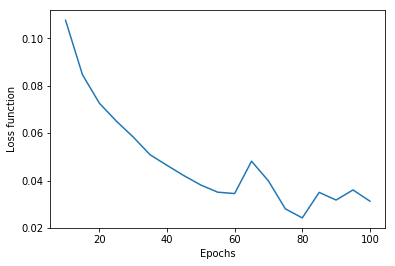

In [66]:
pyplot.plot(epochs, loss_functions)
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss function')
pyplot.show()

El gráfico anterior muestra que el valor final promedio de la función objetivo decae desde 0.10, para 10 épocas, hasta 0.04, para 60 épocas, aproximádamente. Luego, presenta un comportamiento relativamente oscilatorio entre 60 y 100 épocas. Notar, además, que el valor mínimo de la función es de 0.02 para 80 épocas, aproximádamente.

**2.4 Entrenamiento vía *weight decay***

Con el fin de regularizar los pesos de la red, es posible introducir un nuevo término en la función de actualización de estos, conocido como *weight decay*. Este parámetro penaliza a los pesos más grandes de la red, de tal forma que mientras mayor es el peso, mayor es la reducción que experimenta. Con esta práctica se espera evitar que el modelo no sufra de *overfitting*.

Recordar, que hasta ahora, los pesos estaban siendo actualizados en base a la expresión:

**peso_i = peso_i-1 + tasa_de_aprendizaje x error_i-1 x input**

Al incluir el nuevo término, la expresión queda:

**peso_i = peso_i-1 + tasa_de_aprendizaje x error_i-1 x input - tasa_de_aprendizaje x weight_decay * peso_i-1**

El razonamiento es análogo para el bias.

En esta sección, se introduce *weight_decay* dentro del proceso de entrenamiento de la red. Así, se vuelve a estudiar el problema de la sección 2.3 y el modelo es entrado nuevamente, para luego generar predicciones sobre los conjuntos de entrenamiento y de prueba. Se usará *weight_decay* = 0,01 en este caso (la tasa de aprendizaje y el número máximo de épocas se mantienen en 0,03 y 100, respectivamente).

In [68]:
# Se inicializa red
random.seed(1)
network = init_network(n_features, 10, n_classes)

train_errors = []
test_errors = []
loss_functions = []

# Para cada cantidad de épocas posible...
for i in range(10, max_epochs + 5, 5):
    # ... se entrena la red, ...
    train_network(network, train_dataset, learning_rate, i, n_classes, weight_decay=0.01)
    # ... y se obtiene tanto error de clasificación, como valor de la función de perdida
    train_error = predict_classes(network, train_dataset)
    test_error = predict_classes(network, test_dataset)
    train_errors.append(train_error)
    test_errors.append(test_error)
    loss_functions.append(loss_function)

Con ello, es interesante observar como varian las predicciones y los errores por medio de esta modificación. Se procede, entonces, a graficar error v/s número de épocas.

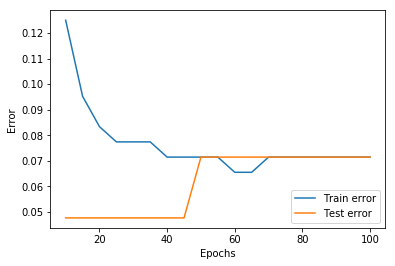

In [69]:
pyplot.plot(epochs, train_errors)
pyplot.plot(epochs, test_errors)
pyplot.xlabel('Epochs')
pyplot.ylabel('Error')
pyplot.legend(['Train error', 'Test error'], loc='lower right')
pyplot.show()

El gráfico anterior muestra que el error de entrenamiento, al igual que en el caso anterior, disminuye a medida que aumenta la cantidad de épocas, siendo su valor mínimo del 6,5%, aproximadamente, para 60 y 65 épocas. Desde este último punto en adelante, el error se mantiene constante en ese valor. De esta manera, el error de entrenamiento aumenta con *weight decay* en comparación con el caso en que este parámetro no fue utilizado.

Por otro lado, el error de pruebas presenta un valor constante del 5%, aproximadamente, entre 10 y 45 épocas, aumentando al 7% desde las 50 épocas en adelante y manteniendo dicho valor hasta alcanzar las 100 épocas. Con ello, se tiene que el error de pruebas presenta una importante disminución al utilizar *weight_decay* en comparación con el caso en que no se utiliza, existiendo un 10,5% de diferencias entre ambas cifras.

Nuevamente se grafica el valor final promedio de la función objetivo en función de la cantidad épocas.

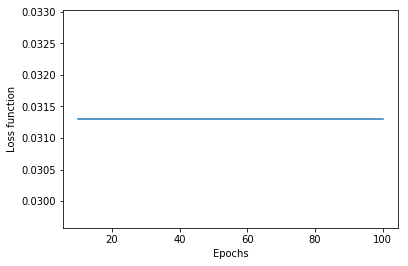

In [70]:
pyplot.plot(epochs, loss_functions)
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss function')
pyplot.show()

El gráfico anterior muestra que el valor final promedio de la función objetivo se mantiene constante, siendo su valor de 0.0315 para cada número de épocas posible.